## Imports

In [1]:
import pandas as pd
from pathlib import Path
import pickle
import numpy as np
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, classification_report
import pprint
import json
import shap

## Envs

In [2]:
input_filepath = '../data/processed/'
output_filepath = '../models/'

# cols
BINARY_COLS = Path.cwd().joinpath(input_filepath).joinpath('binary-cols.pickle')
CATEGORICAL_COLS = Path.cwd().joinpath(input_filepath).joinpath('categorical-cols.pickle')
CONTINUOUS_COLS = Path.cwd().joinpath(input_filepath).joinpath('continuous-cols.pickle')
TARGET_COL = Path.cwd().joinpath(input_filepath).joinpath('target-col.pickle')

BINARY_COLS_OUT = Path.cwd().joinpath(output_filepath).joinpath('binary-cols.pickle')
CATEGORICAL_COLS_OUT = Path.cwd().joinpath(output_filepath).joinpath('categorical-cols.pickle')
CONTINUOUS_COLS_OUT = Path.cwd().joinpath(output_filepath).joinpath('continuous-cols.pickle')
TARGET_COL_OUT = Path.cwd().joinpath(output_filepath).joinpath('target-col.pickle')

COL_ORDER_OUT = Path.cwd().joinpath(output_filepath).joinpath('col-order.pickle')

# data
TRAIN_CSV = Path.cwd().joinpath(input_filepath).joinpath('train.csv')
VAL_CSV = Path.cwd().joinpath(input_filepath).joinpath('val.csv')
TEST_CSV = Path.cwd().joinpath(input_filepath).joinpath('test.csv')

# metadata
BINARY_ENCODERS = Path.cwd().joinpath(input_filepath).joinpath('binary-encoders.pickle')
CATEGORICAL_ENCODERS = Path.cwd().joinpath(input_filepath).joinpath('categorical-encoders.pickle')
TARGET_ENCODERS = Path.cwd().joinpath(input_filepath).joinpath('target-encoders.pickle')
CONTINUOUS_SCALERS = Path.cwd().joinpath(input_filepath).joinpath('continuous-scalers.pickle')

BINARY_ENCODERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('binary-encoders.pickle')
CATEGORICAL_ENCODERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('categorical-encoders.pickle')
TARGET_ENCODERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('target-encoders.pickle')
CONTINUOUS_SCALERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('continuous-scalers.pickle')

# model
MODEL = Path.cwd().joinpath(output_filepath).joinpath('catboost_model.dump')

# model results
VAL_RESULTS = Path.cwd().joinpath(output_filepath).joinpath('val-results.txt')
TEST_RESULTS = Path.cwd().joinpath(output_filepath).joinpath('test-results.txt')

## Load Data

In [3]:
def read_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    return None

In [4]:
# Cols
binary_cols = read_obj(BINARY_COLS)
categorical_cols = read_obj(CATEGORICAL_COLS)
continuous_cols = read_obj(CONTINUOUS_COLS)
target_col = read_obj(TARGET_COL)

# Metadata
ohe_encoders = read_obj(BINARY_ENCODERS)
label_encoders = read_obj(CATEGORICAL_ENCODERS)
scalers = read_obj(TARGET_ENCODERS)
target_encoders = read_obj(CONTINUOUS_SCALERS)

# Data
X_train = pd.read_csv(TRAIN_CSV)
X_val = pd.read_csv(VAL_CSV)
X_test = pd.read_csv(TEST_CSV)

In [5]:
X_train = X_train[binary_cols + categorical_cols + continuous_cols + [target_col]]
X_val = X_val[binary_cols + categorical_cols + continuous_cols + [target_col]]
X_test = X_test[binary_cols + categorical_cols + continuous_cols + [target_col]]

In [6]:
y_train = X_train.pop(target_col)
y_val = X_val.pop(target_col)
y_test = X_test.pop(target_col)

## Modelling

In [7]:
model_args = {
    'custom_loss': ['AUC'],
    'random_seed': 42,
    'logging_level': 'Silent'
}

In [8]:
model = CatBoostClassifier(**model_args)

cat_cols = binary_cols + categorical_cols
model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    logging_level='Verbose',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.064835
0:	learn: 0.6119351	total: 297ms	remaining: 4m 56s
1:	learn: 0.5450366	total: 486ms	remaining: 4m 2s
2:	learn: 0.4924642	total: 676ms	remaining: 3m 44s
3:	learn: 0.4496231	total: 861ms	remaining: 3m 34s
4:	learn: 0.4119313	total: 1.09s	remaining: 3m 36s
5:	learn: 0.3838080	total: 1.2s	remaining: 3m 19s
6:	learn: 0.3551647	total: 1.39s	remaining: 3m 17s
7:	learn: 0.3349317	total: 1.58s	remaining: 3m 15s
8:	learn: 0.3160923	total: 1.76s	remaining: 3m 13s
9:	learn: 0.2990268	total: 1.93s	remaining: 3m 11s
10:	learn: 0.2871304	total: 2.12s	remaining: 3m 10s
11:	learn: 0.2755307	total: 2.3s	remaining: 3m 9s
12:	learn: 0.2657358	total: 2.48s	remaining: 3m 8s
13:	learn: 0.2575243	total: 2.67s	remaining: 3m 7s
14:	learn: 0.2511879	total: 2.85s	remaining: 3m 7s
15:	learn: 0.2450347	total: 3.04s	remaining: 3m 7s
16:	learn: 0.2394700	total: 3.23s	remaining: 3m 7s
17:	learn: 0.2344151	total: 3.42s	remaining: 3m 6s
18:	learn: 0.2299636	total: 3.63s	remaining: 3m 7s
19:

## Results Val

In [9]:
def results(y_true, y_pred, y_proba):
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['f1'] = f1_score(y_true, y_pred)
    fpr, tpr, thresh = roc_curve(y_true, y_proba)
    results['auc'] = auc(fpr, tpr)
    results['classification_report'] = classification_report(y_true, y_pred, output_dict=True)
    return results

In [10]:
y_val_preds = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)
y_val_proba_death = y_val_proba[:,1]

In [11]:
val_results = results(y_val, y_val_preds, y_val_proba_death)
pprint.pprint(val_results)

{'accuracy': 0.9336159903089037,
 'auc': 0.9007473258188633,
 'classification_report': {'0': {'f1-score': 0.964544513457557,
                                 'precision': 0.941994186781246,
                                 'recall': 0.9882009810420257,
                                 'support': 7543},
                           '1': {'f1-score': 0.4800759013282733,
                                 'precision': 0.7397660818713451,
                                 'recall': 0.3553370786516854,
                                 'support': 712},
                           'accuracy': 0.9336159903089037,
                           'macro avg': {'f1-score': 0.7223102073929152,
                                         'precision': 0.8408801343262955,
                                         'recall': 0.6717690298468555,
                                         'support': 8255},
                           'weighted avg': {'f1-score': 0.9227587288620331,
                                        

## Results Test

In [12]:
y_test_preds = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)
y_test_proba_death = y_test_proba[:,1]

In [13]:
test_results = results(y_test, y_test_preds, y_test_proba_death)
pprint.pprint(test_results)

{'accuracy': 0.9333842128216311,
 'auc': 0.9032900605096309,
 'classification_report': {'0': {'f1-score': 0.9644167491701123,
                                 'precision': 0.9418723694687748,
                                 'recall': 0.9880668257756563,
                                 'support': 8380},
                           '1': {'f1-score': 0.4791133844842284,
                                 'precision': 0.7375328083989501,
                                 'recall': 0.3547979797979798,
                                 'support': 792},
                           'accuracy': 0.9333842128216311,
                           'macro avg': {'f1-score': 0.7217650668271703,
                                         'precision': 0.8397025889338625,
                                         'recall': 0.671432402786818,
                                         'support': 9172},
                           'weighted avg': {'f1-score': 0.9225109200345672,
                                       

## Feature Importance

In [14]:
shap_values = model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
expected_values = shap_values[0, -1]
shap_values = shap_values[:, :-1]

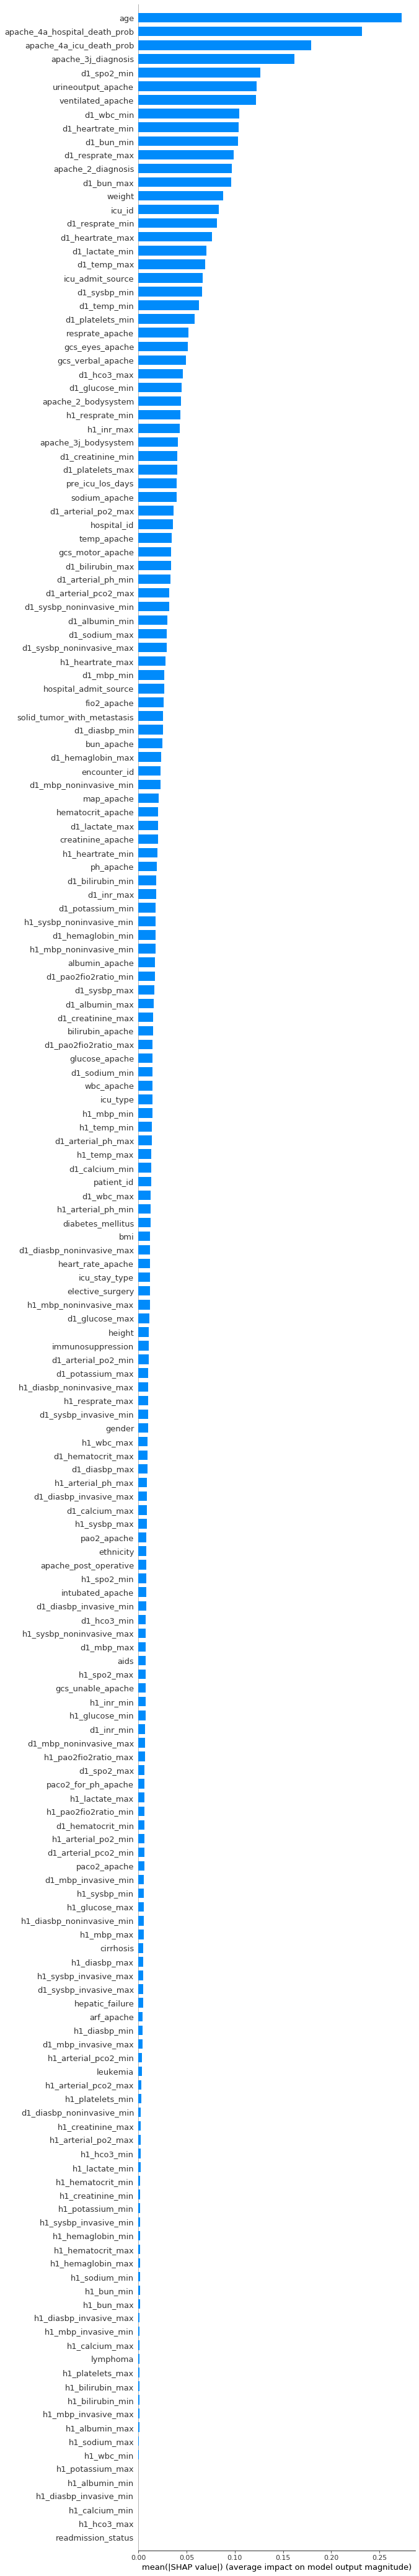

In [30]:
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=200)

In [37]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(40)

,col_name,feature_importance_vals
33,age,0.273458
183,apache_4a_hospital_death_prob,0.232248
184,apache_4a_icu_death_prob,0.179219
23,apache_3j_diagnosis,0.161949
72,d1_spo2_min,0.126632
53,urineoutput_apache,0.122459
6,ventilated_apache,0.121820
136,d1_wbc_min,0.104607
62,d1_heartrate_min,0.104157
112,d1_bun_min,0.103394


In [41]:
pred_power_cols = list(feature_importance.head(40)['col_name'].values)
pred_power_cols

['age',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'apache_3j_diagnosis',
 'd1_spo2_min',
 'urineoutput_apache',
 'ventilated_apache',
 'd1_wbc_min',
 'd1_heartrate_min',
 'd1_bun_min',
 'd1_resprate_max',
 'apache_2_diagnosis',
 'd1_bun_max',
 'weight',
 'icu_id',
 'd1_resprate_min',
 'd1_heartrate_max',
 'd1_lactate_min',
 'd1_temp_max',
 'icu_admit_source',
 'd1_sysbp_min',
 'd1_temp_min',
 'd1_platelets_min',
 'resprate_apache',
 'gcs_eyes_apache',
 'gcs_verbal_apache',
 'd1_hco3_max',
 'd1_glucose_min',
 'apache_2_bodysystem',
 'h1_resprate_min',
 'h1_inr_max',
 'apache_3j_bodysystem',
 'd1_creatinine_min',
 'd1_platelets_max',
 'pre_icu_los_days',
 'sodium_apache',
 'd1_arterial_po2_max',
 'hospital_id',
 'temp_apache',
 'gcs_motor_apache']

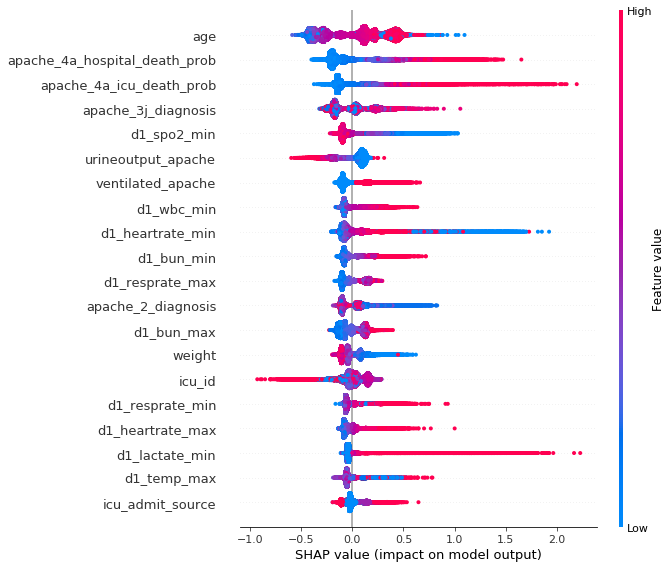

In [21]:
shap.summary_plot(shap_values, X_train)

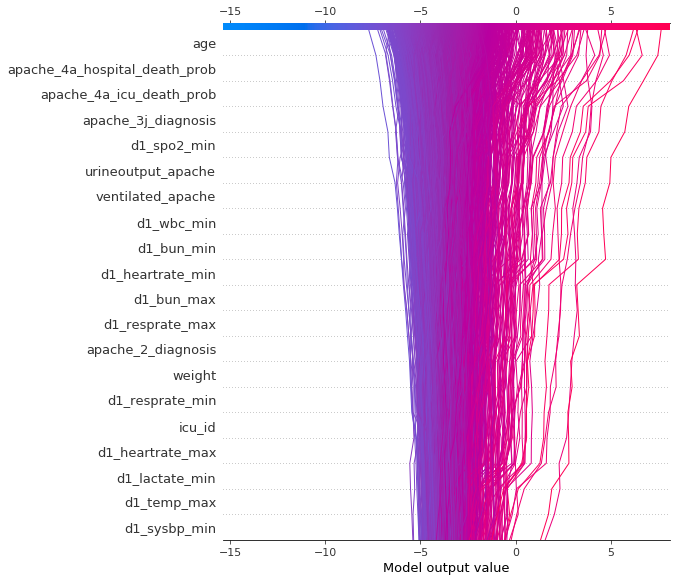

In [23]:
shap.decision_plot(expected_values, shap_values[:2000], feature_names=[x for x in X_train.columns])

## Persist Data

In [24]:
def dump_results(path, results_dict):
    with open(path, 'w') as f:
        f.write(json.dumps(results_dict))

In [25]:
dump_results(VAL_RESULTS, val_results)
dump_results(TEST_RESULTS, test_results)

In [26]:
def pickle_obj(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

In [27]:
# cols
pickle_obj(BINARY_COLS_OUT, binary_cols)
pickle_obj(CATEGORICAL_COLS_OUT, categorical_cols)
pickle_obj(CONTINUOUS_COLS_OUT, continuous_cols)
pickle_obj(TARGET_COL_OUT, target_col)

pickle_obj(COL_ORDER_OUT, list(X_train.columns))

# metadata
pickle_obj(BINARY_ENCODERS_OUT, ohe_encoders)
pickle_obj(CATEGORICAL_ENCODERS_OUT, label_encoders)
pickle_obj(TARGET_ENCODERS_OUT, target_encoders)
pickle_obj(CONTINUOUS_SCALERS_OUT, scalers)

In [28]:
model.save_model(str(MODEL))